In [1]:
import random
random.seed(42)

In [2]:
import numpy as np 
import pandas as pd 
 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.metrics import  confusion_matrix, f1_score, make_scorer, recall_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler  
from sklearn.neighbors import KNeighborsClassifier 

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE 
import matplotlib.pyplot as plt 

df = pd.read_csv('journeys.csv') 
targets = df['Conversion'] 
df.drop(['Journey Start Date', 'Journey End Date', 'Events Combo', 'User-Journey'], axis=1, inplace=True) 
df = pd.get_dummies(df) 
 
X_train, X_test, y_train, y_test = train_test_split(df, targets, test_size=0.3) 
X_train.drop(['Conversion'], axis=1, inplace=True) 
X_test.drop(['Conversion'], axis=1, inplace=True) 

scaler = StandardScaler() 
scaler.fit(X_train) 
 
s_X_train = scaler.transform(X_train) 
s_X_test = scaler.transform(X_test) 

X_train = pd.DataFrame(s_X_train, columns = X_train.columns)
X_test = pd.DataFrame(s_X_test, columns = X_test.columns)

In [3]:
os = SMOTE(random_state=0)
columns = X_train.columns

os_data_X, os_data_y = os.fit_resample(X_train, y_train)
X_train = pd.DataFrame(data=os_data_X, columns=columns)
y_train = pd.DataFrame(data=os_data_y, columns=['Conversion'])

In [4]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [5]:
param_grid = { 
    'min_samples_split': [3, 5, 10],  
    'n_estimators' : [300], 
    'max_depth': [3, 5, 15, 25], 
    'max_features': [3, 5, 10, 19]

} 
  
#https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65  
def grid_search_wrapper(_model = '', param_grid=param_grid): 
    grid_search = GridSearchCV(_model, param_grid, scoring=make_scorer(f1_score),
        return_train_score=True, n_jobs=-1, error_score='raise', cv=10) 
    grid_search.fit(X_train, y_train) 
 
    # make the predictions 
    y_pred = grid_search.predict(X_test) 
 
    print('Best params for {}'.format('f1')) 
    print(grid_search.best_params_) 
 
    # confusion matrix on the test data. 
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format('f1')) 
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos'])) 
    return grid_search

def show_model_output(grid_search_output, num_to_show = 10): 
    try:
        df1 = pd.DataFrame(grid_search_output.cv_results_['params'])
        df2 = pd.DataFrame(grid_search_output.cv_results_['mean_train_score']).rename(columns={0: "mean_train_score"})
        df3 = pd.DataFrame(grid_search_output.cv_results_['mean_test_score']).rename(columns={0: "mean_out_of_sample_estimate_score"})
        result = pd.concat([df2,df3,df1], axis = 1).sort_values(by='mean_out_of_sample_estimate_score', ascending=False)
        result = result.head(num_to_show)
    except Exception:
    ## for some reason logistic regression doesnt have mean_train_score
        df1 = pd.DataFrame(grid_search_output.cv_results_['params'])
        df3 = pd.DataFrame(grid_search_output.cv_results_['mean_test_score']).rename(columns={0: "mean_out_of_sample_estimate_score"})
        result = pd.concat([df3,df1], axis = 1).sort_values(by='mean_out_of_sample_estimate_score', ascending=False)
        result = result.head(num_to_show)
    return result



### Random Forest

In [6]:
clf = RandomForestClassifier(n_jobs=-1)
grid_search_clf = grid_search_wrapper(_model = clf, param_grid=param_grid) 
#y_scores = grid_search_clf.predict_proba(X_test)[:, 1]  

Best params for f1
{'max_depth': 15, 'max_features': 19, 'min_samples_split': 5, 'n_estimators': 300}

Confusion matrix of Random Forest optimized for f1 on the test data:
     pred_neg  pred_pos
neg      1869        64
pos       116       189


In [7]:
show_model_output(grid_search_output= grid_search_clf, num_to_show=10)

,mean_train_score,mean_out_of_sample_estimate_score,max_depth,max_features,min_samples_split,n_estimators
34,0.861940,0.842500,15,19,5,300
46,0.863593,0.842485,25,19,5,300
45,0.866467,0.842286,25,19,3,300
33,0.863673,0.841926,15,19,3,300
42,0.866276,0.841753,25,10,3,300
35,0.858667,0.841165,15,19,10,300
47,0.860706,0.841128,25,19,10,300
26,0.855481,0.840873,15,3,10,300
31,0.860267,0.840800,15,10,5,300
32,0.857338,0.840631,15,10,10,300


### Logistic Regression

In [8]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 7),
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
}

In [9]:
logreg = LogisticRegression(random_state=42)
log_reg = GridSearchCV(logreg, param_grid=param_grid, scoring=make_scorer(f1_score), cv=10)
log_reg.fit(X_train, y_train)

C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Mark\AppData\Local\Programs\Python\Py

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring=make_scorer(f1_score))

In [10]:
show_model_output(grid_search_output= log_reg, num_to_show=10)

,mean_out_of_sample_estimate_score,C,penalty,solver
22,0.682056,1.0,l2,lbfgs
23,0.682056,1.0,l2,liblinear
40,0.682056,1000.0,l2,lbfgs
39,0.682056,1000.0,l2,newton-cg
38,0.682056,1000.0,l1,liblinear
35,0.682056,100.0,l2,liblinear
34,0.682056,100.0,l2,lbfgs
33,0.682056,100.0,l2,newton-cg
32,0.682056,100.0,l1,liblinear
29,0.682056,10.0,l2,liblinear


In [11]:
# https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [12]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [13]:
grid_search_xgb = grid_search_wrapper(_model = xgb, param_grid=param_grid) 

C:\Users\Mark\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:47:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "C", "penalty", "silent", "solver" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:47:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params for f1
{'C': 0.001, 'penalty': 'l1', 'solver': 'newton-cg'}

Confusion matrix of Random Forest optimized for f1 on the test data:
     pred_neg  pred_pos
neg      1870        63
pos       111       194


In [14]:
show_model_output(grid_search_output= grid_search_xgb, num_to_show=10)

,mean_train_score,mean_out_of_sample_estimate_score,C,penalty,solver
0,0.857132,0.846807,0.001,l1,newton-cg
31,0.857132,0.846807,100.000,l1,lbfgs
23,0.857132,0.846807,1.000,l2,liblinear
24,0.857132,0.846807,10.000,l1,newton-cg
25,0.857132,0.846807,10.000,l1,lbfgs
26,0.857132,0.846807,10.000,l1,liblinear
27,0.857132,0.846807,10.000,l2,newton-cg
28,0.857132,0.846807,10.000,l2,lbfgs
29,0.857132,0.846807,10.000,l2,liblinear
30,0.857132,0.846807,100.000,l1,newton-cg


### SHAP

##### Random Forest

In [15]:
import shap
model1 = grid_search_clf.best_estimator_.fit(X_train, y_train)
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_train)


In [16]:
y_pred = model1.predict(X_test)
report = classification_report(y_test, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1933
           1       0.74      0.62      0.68       305

    accuracy                           0.92      2238
   macro avg       0.84      0.79      0.82      2238
weighted avg       0.91      0.92      0.92      2238



In [17]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.6773618538324421

In [18]:
import matplotlib.pyplot as plt

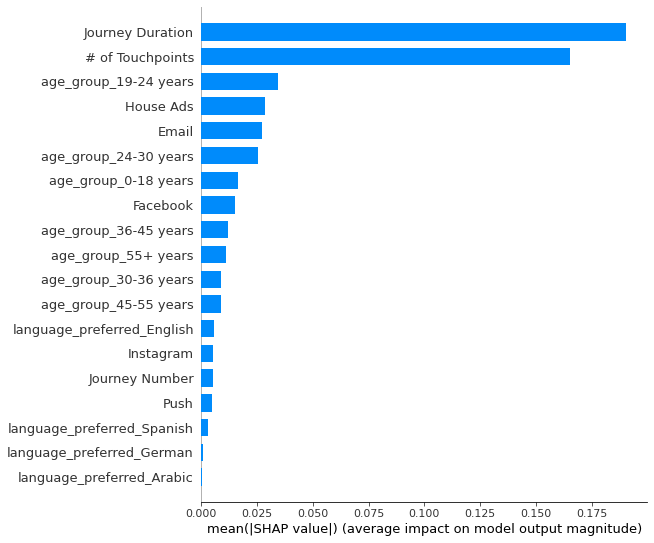

In [19]:
shap.summary_plot(shap_values[1], X_train, plot_type = 'bar', class_names=model1.classes_)

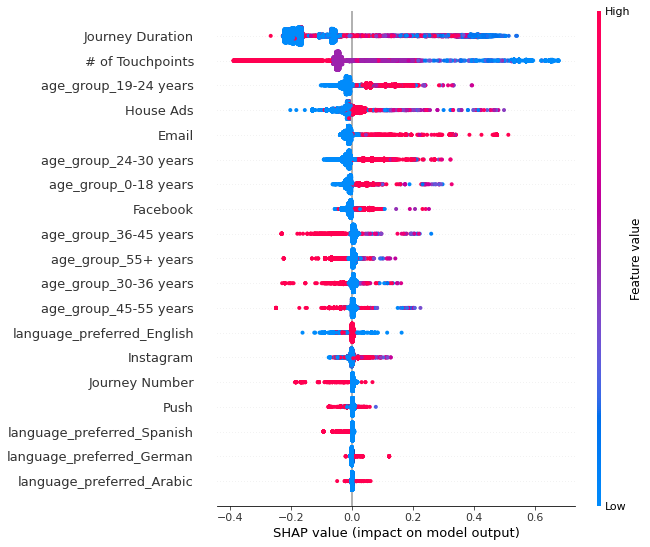

In [20]:
shap.summary_plot(shap_values[1], X_train, class_names=model1.classes_)

##### Logistic Regression

In [22]:
model2 = log_reg.best_estimator_.fit(X_train, y_train)
explainer = shap.Explainer(model2, X_train)
shap_values = explainer.shap_values(X_train)

In [23]:
y_pred = model2.predict(X_test)
report = classification_report(y_test, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.93      0.64      0.76      1933
           1       0.23      0.69      0.35       305

    accuracy                           0.65      2238
   macro avg       0.58      0.67      0.56      2238
weighted avg       0.84      0.65      0.71      2238



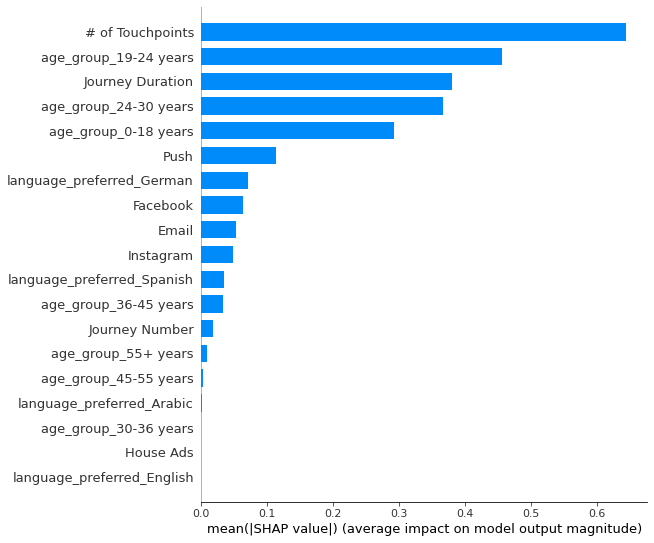

In [24]:
plt.figure(figsize=((10,8)))
shap.summary_plot(shap_values, X_train, plot_type="bar", class_names=model2.classes_, show=False)

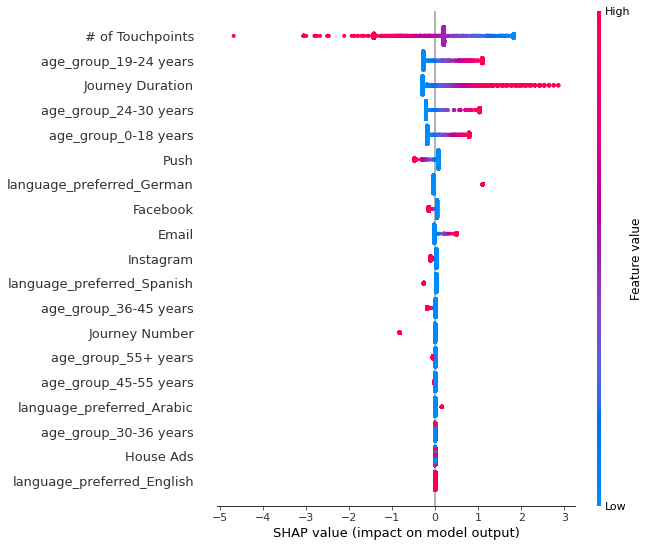

In [25]:
shap.summary_plot(shap_values, X_train, plot_type="dot", class_names=model2.classes_)

##### XGBooost

In [46]:
model3 = grid_search_xgb.best_estimator_.fit(X_train, y_train)
explainer = shap.Explainer(model3, X_train)
shap_values = explainer.shap_values(X_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:56:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "C", "penalty", "silent", "solver" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:56:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 99%|===================| 8909/8972 [01:16<00:00]        

In [47]:
y_pred = model3.predict(X_test)
report = classification_report(y_test, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1933
           1       0.75      0.64      0.69       305

    accuracy                           0.92      2238
   macro avg       0.85      0.80      0.82      2238
weighted avg       0.92      0.92      0.92      2238



In [48]:
FP = X_test[(y_test == 0) & (y_pred == 1)]

In [52]:
FP

,Journey Number,# of Touchpoints,Journey Duration,Email,Facebook,House Ads,Instagram,Push,age_group_0-18 years,age_group_19-24 years,age_group_24-30 years,age_group_30-36 years,age_group_36-45 years,age_group_45-55 years,age_group_55+ years,language_preferred_Arabic,language_preferred_English,language_preferred_German,language_preferred_Spanish
22,-0.155329,1.820328,-0.014935,3.973384,-0.529715,0.957795,-0.540081,-0.379081,-0.431649,-0.460971,2.338726,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161
38,-0.155329,-0.325514,-0.400001,3.973384,-0.529715,-1.044065,-0.540081,-0.379081,2.316694,-0.460971,-0.427583,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161
53,-0.155329,1.820328,-0.014935,-0.251675,-0.529715,0.957795,1.851575,-0.379081,-0.431649,2.169334,-0.427583,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161
105,-0.155329,-0.325514,-0.400001,3.973384,-0.529715,-1.044065,-0.540081,-0.379081,-0.431649,2.169334,-0.427583,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161
127,-0.155329,-0.325514,-0.400001,3.973384,-0.529715,-1.044065,-0.540081,-0.379081,-0.431649,2.169334,-0.427583,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2117,-0.155329,-0.325514,-0.400001,-0.251675,-0.529715,0.957795,-0.540081,-0.379081,-0.431649,-0.460971,-0.427583,-0.392189,-0.385989,2.673029,-0.382049,-0.120725,-3.669142,7.965977,-0.202161
2134,-0.155329,1.820328,-0.207468,-0.251675,-0.529715,0.957795,1.851575,-0.379081,-0.431649,-0.460971,2.338726,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161
2155,-0.155329,1.820328,0.370131,-0.251675,-0.529715,0.957795,1.851575,-0.379081,-0.431649,2.169334,-0.427583,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161
2166,-0.155329,-0.325514,-0.400001,3.973384,-0.529715,-1.044065,-0.540081,-0.379081,-0.431649,-0.460971,2.338726,-0.392189,-0.385989,-0.374107,-0.382049,-0.120725,0.272543,-0.125534,-0.202161


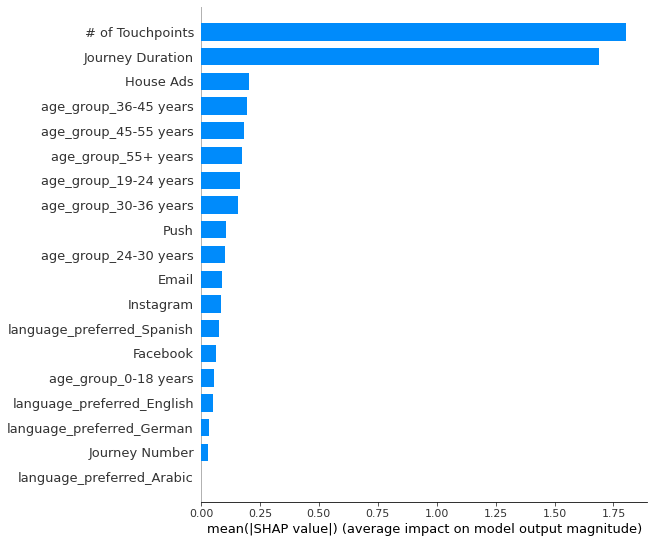

In [28]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

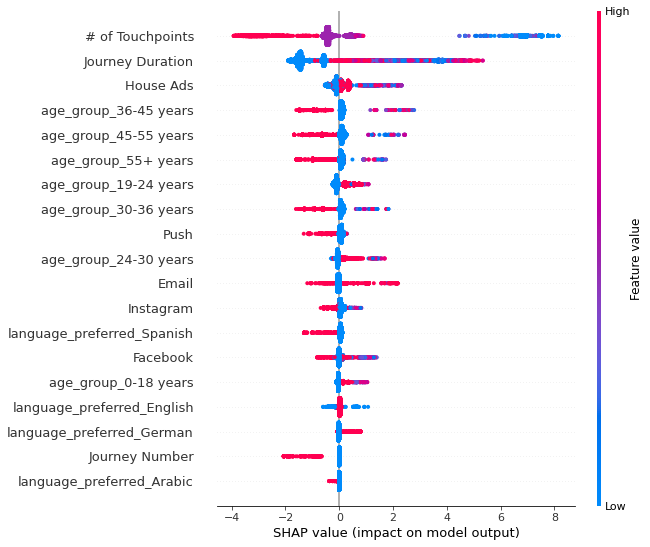

In [29]:
shap.summary_plot(shap_values, X_train, plot_type="dot", class_names=model3.classes_)

##### KNN

In [32]:
k_range = list(range(1, 50))
knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=k_range)
grid = grid_search_wrapper(_model = knn, param_grid=param_grid) 


Best params for f1
{'n_neighbors': 4}

Confusion matrix of Random Forest optimized for f1 on the test data:
     pred_neg  pred_pos
neg      1858        75
pos       122       183


In [33]:
show_model_output(grid)

,mean_train_score,mean_out_of_sample_estimate_score,n_neighbors
3,0.830832,0.806962,4
4,0.830208,0.806376,5
0,0.845578,0.806108,1
6,0.823247,0.805144,7
2,0.833524,0.805127,3
5,0.824508,0.802904,6
7,0.819008,0.799513,8
8,0.819364,0.798019,9
10,0.812428,0.794596,11
9,0.813181,0.794477,10


In [38]:
model4 = grid_search_clf.best_estimator_.fit(X_train, y_train)
explainer = shap.Explainer(model4, X_train)
shap_values = explainer.shap_values(X_train)

100%|===================| 17940/17944 [05:32<00:00]        

Exception: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.068025, while the model output was 0.073714. If this difference is acceptable you can set check_additivity=False to disable this check.

In [39]:
y_pred = model4.predict(X_test)
report = classification_report(y_test, y_pred) 
print(report)

              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1933
           1       0.74      0.62      0.67       305

    accuracy                           0.92      2238
   macro avg       0.84      0.79      0.81      2238
weighted avg       0.91      0.92      0.92      2238



In [41]:
#shap.summary_plot(shap_values, X_train, plot_type="bar")

In [42]:
#shap.summary_plot(shap_values, X_train, plot_type="dot", class_names=model4.classes_)

In [54]:
df['Conversion'].sum()

1040

In [55]:
df.shape

(7459, 20)

In [56]:
df.shape - df['Conversion'].sum()

array([ 6419, -1020])

In [61]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

##### Import Serena's code

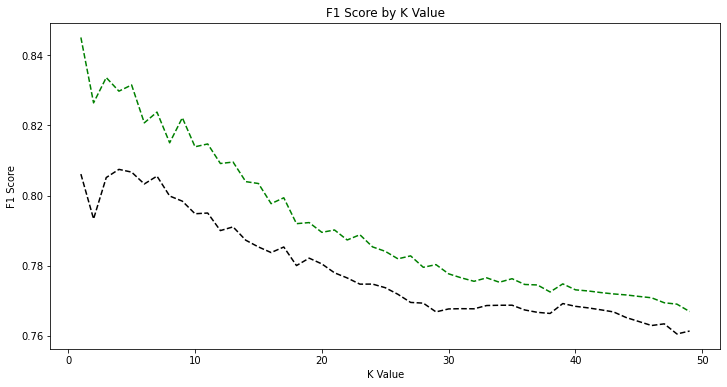

In [70]:
cv = []
f_score = []

for i in range(1, 50):
    knn_cv = KNeighborsClassifier(n_neighbors=i)
    cv.append((cross_val_score(knn_cv, X_train, y_train, cv=10, scoring='f1')).mean())
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_train)
    # error.append(np.mean(pred_i != y_test))
    # accuracy.append(np.mean(pred_i == y_test))
    f_score.append(metrics.f1_score(y_train, list(pred_i)))



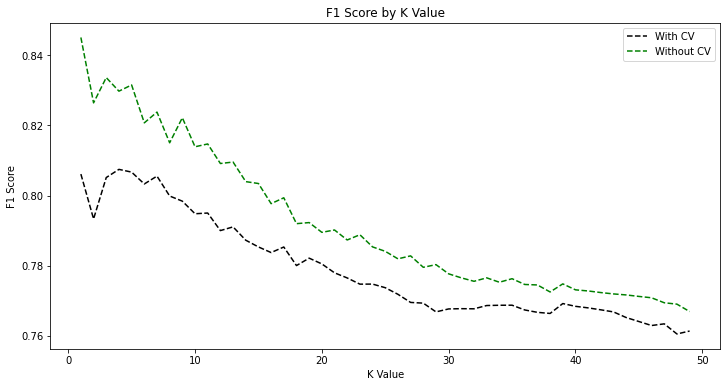

In [75]:
plt.figure(figsize=(12, 6))
# plt.plot(range(k_min, k_max), f_score, color='black', linestyle='dashed', marker='x',
# markerfacecolor='green', markersize=10)
plt.plot(range(1, 50), cv, color='black', linestyle='dashed')
plt.plot(range(1, 50), f_score, color='green', linestyle='dashed')
# plt.plot(range(k_min, k_max), accuracy, color='green', linestyle='dashed')
plt.title('F1 Score by K Value')
plt.xlabel('K Value')
plt.ylabel('F1 Score')
plt.legend(['With CV','Without CV'])
plt.savefig('img.png', facecolor='w')